# Twitter Sentiment Analysis
Author: Brenda De Leon

<img src=“url/filename.gif” alt=“Alt text” title=“Title text” />
### Overview
### Business Understanding

### Data Understanding

#### Data Source
##### Data Limitations:
#### Features
#### Target

In [120]:
# importing relevant libraries
# !pip install wordcloud
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import string
from textwrap import wrap
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk import FreqDist 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

### Data
We will import the data and review content to assess next steps. 

In [121]:
# importing data
df = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
# previewing data
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [122]:
# viewing columns, # of columns, dtypes, # of rows, # of non nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [123]:
# inspecting data value ranges
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,8720,3169,8721
unique,8693,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,910,5156


#### Renaming Columns
The column names are not convenient. We will rename column titles to make them succinct and descriptive. We will preview column values to assure most accurate new titles.

In [124]:
# previewing 'tweet_text' values
df['tweet_text'].value_counts(dropna=False)[:25]

RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                      5
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                      4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                                   4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                                   3
Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!                     2
Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                                  2
I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come S

In [125]:
# previewing 'emotion_in_tweet_is_directed_at' values
df['emotion_in_tweet_is_directed_at'].value_counts(dropna=False)

NaN                                5552
iPad                                910
Apple                               640
iPad or iPhone App                  451
Google                              412
iPhone                              288
Other Google product or service     282
Android App                          78
Android                              74
Other Apple product or service       34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [126]:
# previewing 'is_there_an_emotion_directed_at_a_brand_or_product' values
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(dropna=False)

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [127]:
# renaming columns 
df = df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product':'Sentiment',
                          'tweet_text':'Tweet', 
                          'emotion_in_tweet_is_directed_at':'Brand_or_Product'}
              )

#### Handling Nulls
Missing values are incompatible with scikit-learn models, all values are expected to have and hold meaning. [(sci-kit learn)](https://scikit-learn.org/stable/modules/impute.html)

In [128]:
# checking for nulls and confirming new column titles
df.isnull().sum()

Tweet                  1
Brand_or_Product    5552
Sentiment              0
dtype: int64

In [129]:
# inspecting the single null in tweet column
df.loc[df['Tweet'].isnull()]

,Tweet,Brand_or_Product,Sentiment
6,NaN,NaN,No emotion toward brand or product


In [130]:
# dropping single null in tweet column
df.dropna(subset=['Tweet'], inplace = True)
# confirming null was dropped
df['Tweet'].isnull().sum()

0

We dropped the single null in the tweet column as it's other values were also indeterminate. We will now address the remaining null values.

In [131]:
# inspecting the null values in product or service column
df.loc[df['Brand_or_Product'].isnull()]

,Tweet,Brand_or_Product,Sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product
...,...,...,...
8715,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


The null values in the brand or product column seem to coincide with the "no emotion" sentiment values. The missing value in the 'brand or product' column does not specify which service or product the "no emotion" sentiment is addressed towards. However, we can see the some of the coinciding tweets to reveal a specific possible product or service. We will fill in the nulls with 'Unknown' values and later revisit it to see if we can extract information from the tweet values to determine the actual 'brand or product' value.

In [132]:
# fill in 'brand or product' nulls with 'Unknown' 
df['Brand_or_Product'].fillna(value='Unknown', inplace=True)
# confirming no remaining nulls
df.isnull().sum()

Tweet               0
Brand_or_Product    0
Sentiment           0
dtype: int64

#### Handling Duplicates
We will analyze the duplicates to determine if they need to be removed.

In [133]:
# checking for duplicates
df.duplicated().sum()

22

In [134]:
# inspecting duplicate rows
df.loc[df.duplicated(keep=False)]

,Tweet,Brand_or_Product,Sentiment
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
20,Need to buy an iPad2 while I'm in Austin at #s...,iPad,Positive emotion
21,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
24,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
455,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
457,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
750,Google to Launch Major New Social Network Call...,Unknown,No emotion toward brand or product
752,Google to Launch Major New Social Network Call...,Unknown,No emotion toward brand or product


After previewing column value counts and inspecting duplicates, we conclude that the duplicates are retweets. A retweet is a twitter feature that allows users to quickly share an existing tweet to their own followers. [(Twitter FAQ)](https://help.twitter.com/en/using-twitter/retweet-faqs#:~:text=A%20Retweet%20is%20a%20re,re%2Dposting%20someone%20else's%20content.) These duplicates are therefore intentional and are meant to show an agreement, we will keep the duplicates. 

### Identify/Clean Target
We are classifying the sentiment being expressed through the tweet. 'Sentiment' column will serve as the target. Let's look through our target.

In [135]:
# inspecting 'Sentiment' 
df['Sentiment'].value_counts(dropna=False)

No emotion toward brand or product    5155
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: Sentiment, dtype: int64

In [136]:
# creating plot labels
labels = ['No emotion toward brand or product','Positive emotion','Negative emotion','I can\'t tell']
# adding line break to labels to better fit in plot
labels = [ '\n'.join(wrap(l, 12)) for l in labels ]

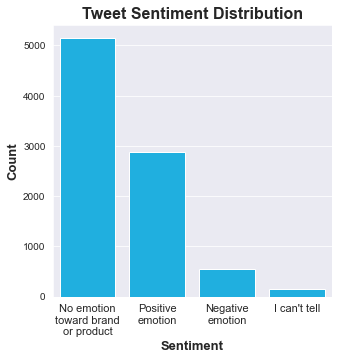

In [147]:
# visual distribution of overall sentiment values
descending = df.groupby('Sentiment').size().sort_values().index[::-1]
plt.figure(figsize=(5,5))
sns.countplot(x=df['Sentiment'], 
              data=df,
              order=descending,
              color='deepskyblue')
plt.xlabel('Sentiment', weight='bold', fontsize=13)
plt.xticks([0,1,2,3], labels, rotation=0, fontsize=11)
plt.ylabel('Count', weight='bold', fontsize=13)
plt.title('Tweet Sentiment Distribution', weight='bold', size=16);

In [115]:
df['Sentiment'].value_counts(dropna=False, normalize=True)

No emotion toward brand or product    0.591170
Positive emotion                      0.329014
Negative emotion                      0.062500
I can't tell                          0.017317
Name: Sentiment, dtype: float64

In [116]:
# counting number of tweets with "I can't tell" as a sentiment value
len(df.loc[df['Sentiment'] == "I can't tell"])

151

Distribution summary of target: More than half of the tweets have been determined to be of neutral sentiment. A significant amount of tweets are of positive sentiment, about 33%. Only a small amount of tweets are of negative sentiment, about 6%. We have an imbalanced classification problem involving four classes. If the model does not support imbalanced classification problems, we will need to modify the parameters to factor in the target's imbalance. Only 151 or about 2% of the tweets have been determined to not have an explicit sentiment and have been labeled as having an "I can't tell sentiment". We will revisit this value. With so few values we will consider whether to drop tweets with "I can't tell" sentiment values or look into whether we can use the tweet text to reclassify the sentiment value into one of the other three sentiment values (ie: TextBlob). 

We will rename the sentiment values so that they are concise while creating a new explicit target column and then move on to the features. 

In [149]:
# defining dictionary map and mapping dictionary on column
# keeping "I can't tell" as is for now
sentiment_map = {
    'No emotion toward brand or product': 'Neutral',
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    "I can't tell": "I can't tell"}

df['target'] = df['Sentiment'].map(sentiment_map)
df['target'].value_counts(dropna=False)

Neutral         5155
Positive        2869
Negative         545
I can't tell     151
Name: target, dtype: int64

### Data Cleaning
We will explore the features and consider engineering additional features. 
The data needs to be able to fit a scikit-learn model. We will standardize the case of the data, use a tokenizer to convert the full tweets into lists of individual words. We will then compare the raw word frequency distributions of each sentiment. 

#### Feature: Brand or Product

In [148]:
# inspecting 'Brand or Product' feature
df['Brand_or_Product'].value_counts(dropna=False)

Unknown                            5551
iPad                                910
Apple                               640
iPad or iPhone App                  451
Google                              412
iPhone                              288
Other Google product or service     282
Android App                          78
Android                              74
Other Apple product or service       34
Name: Brand_or_Product, dtype: int64

Reviewing the values, we can see that it is possible to make create a column solely for Brand.

In [151]:
# defining dictionary for brand and mapping dictionary on the 'Brand or Product' values
brand_dict = {
    'Unknown': "Unknown",
    'iPad': "Apple",
    'Apple': "Apple",
    'iPad or iPhone App': "Apple",
    'Google': "Google",
    'iPhone': "Apple",
    'Other Google product or service': "Google",
    'Android App': "Google",
    'Android': "Google",
    'Other Apple product or service': "Apple"}
# creating new 'Brand' column
df['Brand'] = df['Brand_or_Product'].map(brand_dict)
# confirming new column
df['Brand'].value_counts(dropna=False, normalize=True)

Unknown    0.636583
Apple      0.266399
Google     0.097018
Name: Brand, dtype: float64

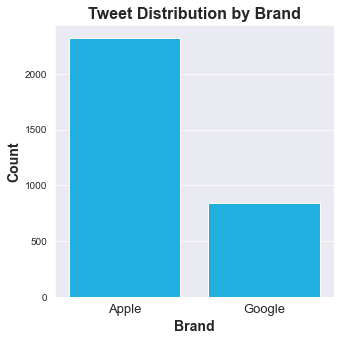

In [175]:
# visual distribution of Apple and Google brand values
plt.figure(figsize=(5,5))
classes = ['Apple', 'Google']
sns.countplot(x=df['Brand'], 
              data=df, 
              order=classes,
              color='deepskyblue')
plt.xlabel('Brand', weight='bold', fontsize=14)
plt.xticks(fontsize=13)
plt.ylabel('Count', weight='bold', fontsize=14)
plt.title('Tweet Distribution by Brand', weight='bold', size=16);

Our new column makes it clear that there are many unknowns, at 63%. We can also see that there are far fewer tweets about Google compared to tweets about Apple. We will see if we are able to convert any of the unknown brand values to apple of google.

#### Feature: Tweet

In [154]:
# inspecting 'Brand or Product' feature
df['Tweet'].value_counts(dropna=False)

RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                               5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                            4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                               4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                            3
Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                           2
                                                                                                                                            ..
If you haven't already, download the (free) #SXSW music sampler from iTunes {link} (iTunes link). It's good!                                 1

In [166]:
# inspecting full text of a tweet
df.Tweet[10]

'Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail'

We will create new column with processed 'Tweet' text, where the text will be transformed into a list of words.

In [169]:
processed_data = [d.split() for d in df['Tweet'].to_list()]
print(processed_data[:2])

[['.@wesley83', 'I', 'have', 'a', '3G', 'iPhone.', 'After', '3', 'hrs', 'tweeting', 'at', '#RISE_Austin,', 'it', 'was', 'dead!', 'I', 'need', 'to', 'upgrade.', 'Plugin', 'stations', 'at', '#SXSW.'], ['@jessedee', 'Know', 'about', '@fludapp', '?', 'Awesome', 'iPad/iPhone', 'app', 'that', "you'll", 'likely', 'appreciate', 'for', 'its', 'design.', 'Also,', "they're", 'giving', 'free', 'Ts', 'at', '#SXSW']]


In [ ]:
create new column with hashtags from tweets

In [ ]:
detertmine which preprocessing should be done before test train split
google 
check in


In [ ]:
# a example of the text  
df.tweet[0]

# 
tokenize
stopword removal nltk nltk.download
stop_words=set(stopwords.words)
add stopwords
Lexicon Normalization - lemmatization
Lemmatization
returns real words. Reduces inflected words properly ensuring the root word belongs to the language.
from nltk.stem import WordNetLemmatizer 22:21
    lematized_review=[]
    for w in filtered review:
        lemmatization 
Feature engineering, bag of words: Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer     
# convert a collection of text documents to a matrix of token counts
features = [ , ]

however, TFIDF instead of BoW, it weighs the uniqueness of a word
same instantiate and transform 


--- smote can also be done to text data


In [118]:
# split tweet_text to create unprocessed_text - we'll make a visualization with this and compare it with preprocessed_text
# df['unprocessed_text'] = df['tweet_text'].str.split()

In [89]:
# inspecting tweets with "I can't tell" sentiment values  
for i in df.loc[df['Sentiment'] == "I can't tell"]['Tweet']:
    print(i)

Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh
���@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow
Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw
The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw
Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link}
SYD #SXSW crew your iPhone extra juice pods have been procured.
Why Barry Diller thinks iPad only content is nuts @mention #SXSW {link}
Gave into extreme temptation at #SXSW and bought an iPad 2... #impulse
Catch 22��_ I mean iPad 2 at #SXSW : {link}
Forgot my iPhone for #sxsw. Android only. Knife to a gun fight
Kawasaki: key to enchantment = trustworthiness of Zappos + likeability of Richard Branson + product of Apple #sxsw #mccannsxs

In [93]:
# inspecting tweets with "I can't tell" sentiment values  
for i in df.loc[df['Sentiment'] == "No emotion toward brand or product"]['Tweet'][:30]:
    print(i)

@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd
Holler Gram for iPad on the iTunes App Store -  http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw
Attn: All  #SXSW frineds, @mention Register for #GDGTLive  and see Cobra iRadar for Android. {link}
Anyone at  #sxsw want to sell their old iPad?
Anyone at  #SXSW who bought the new iPad want to sell their older iPad to me?
At #sxsw.  Oooh. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link}
SPIN Play - a new concept in music discovery for your iPad from @mention &amp; spin.com {link} #iTunes #sxsw @mention
VatorNews - Google And Apple Force Print Media to Evolve? {link} #sxsw
HootSuite - HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Whether you�۪re getting friend... {link}
Hey #SXSW - How long do you think it takes us to make an iPhone case? answer @mention using #zazzlesxsw and we�۪ll m

### Build and Evaluate a Baseline Model with TfidfVectorizer and MultinomialNB
Ultimately all data must be in numeric form in order to be able to fit a scikit-learn model. So we'll use a tool from sklearn.feature_extraction.text to convert all data into a vectorized format.

Initially we'll keep all of the default parameters for both the vectorizer and the model, in order to develop a baseline score.

In [ ]:
############## Requirements
1. Load the Data
Use pandas and sklearn.datasets to load the train and test data into appropriate data structures. Then get a sense of what is in this dataset by visually inspecting some samples.

2. Perform Data Cleaning and Exploratory Data Analysis with nltk
Standardize the case of the data and use a tokenizer to convert the full posts into lists of individual words. Then compare the raw word frequency distributions of each category.

3. Build and Evaluate a Baseline Model with TfidfVectorizer and MultinomialNB
Ultimately all data must be in numeric form in order to be able to fit a scikit-learn model. So we'll use a tool from sklearn.feature_extraction.text to convert all data into a vectorized format.

Initially we'll keep all of the default parameters for both the vectorizer and the model, in order to develop a baseline score.

4. Iteratively Perform and Evaluate Preprocessing and Feature Engineering Techniques
Here you will investigate three techniques, to determine whether they should be part of our final modeling process:

Removing stopwords
Using custom tokens
Domain-specific feature engineering
Increasing max_features
5. Evaluate a Final Model on the Test Set
Once you have chosen a final modeling process, fit it on the full training data and evaluate it on the test data.

data limitations: 
subjective, "Oooh" might be positive but was interpreted as i cant tell

next steps:
more accurate sentim ent determiners/ humans, saw a couple of tweets that were mislabeled 
